In [ ]:
#source: https://github.com/rajatrai16921/Brain-Tumor-Segmentation/blob/main/BraTS_scratch.ipynb 

In [ ]:
"""data 증강의 방법
1. noise 만듦
2. pix2pix 등의 GAN 이용, virtual image 만듦
"""

'data 증강의 방법\n1. noise 만듦\n2. pix2pix 등의 GAN 이용, virtual image 만듦\n'

In [1]:
#drive에 마운트

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#저장 경로 설정후 압축 풀기

#%cd "/content/drive/My Drive/졸업설계2"
#!unzip -qq "/content/drive/MyDrive/졸업설계2/BraTS2020.zip"

In [2]:
%cd "/content/drive/My Drive/졸업설계2"

/content/drive/My Drive/졸업설계2


In [4]:
#unet repository cloning
! pip -qq install git+https://github.com/qubvel/segmentation_models.pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00


In [5]:
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib 
from tqdm import tqdm
from segmentation_models_pytorch import utils


In [ ]:

#pining root directory, panda dataframe으로 만들기
root = '/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data = pd.read_csv('/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
data.head(5)


,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [ ]:
#category 별로 data 분류

rootlist = [] # [] 빈 배열을 만들 때 사용
totlist = []
for filename_root in tqdm(np.sort(os.listdir(root))[:-2]): #directory return --> np.sort():원래 배열 둔 채 복사본 정렬-->tqdm 감싸서 프로세스 나타냄 -->반복가능한 만큼 반복
    subpath = os.path.join(root, filename_root)#새로운 경로 생성
    filelist = []
    for filename in np.sort(os.listdir(subpath)):#디렉토리 파일, 리스트 지정하여 정렬
        filelist.append(os.path.join(subpath, filename))#뒤에 붙이기
    rootlist.append(filename_root)
    totlist.append(filelist)
    
maps = pd.concat([pd.DataFrame(rootlist, columns = ['DIR']), #동일한 형태 dataframe 합치기
                  pd.DataFrame(totlist, columns = ['flair', 'seg', 't1', 't1ce', 't2'])], axis = 1)

maps.to_csv('links.csv', index = False)#디렉토리 담은 리스트 csv파일로 변환


100%|██████████| 369/369 [00:28<00:00, 12.97it/s] 


In [ ]:

imgpath = {
              'seg': [],    
              't1': [],
              't1ce': [],
              't2': [],
              'flair': []
          } #dictionary 생성, 각각의 데이터에 접근할 이름 부여

for path in data['BraTS_2020_subject_ID']:
    patient = os.path.join(root, path)#새로운 경로 생성
    for name in imgpath:
      imgpath[name].append(os.path.join(patient, path + f'_{name}.nii'))
imgpath['seg'][:5]# 연결 확인


['/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii',
 '/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii',
 '/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii',
 '/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_seg.nii',
 '/content/drive/MyDrive/졸업설계2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii']

In [ ]:

def loadimg(imgpath):#경로 지정한 이미지 로딩
    return nib.load(imgpath).get_fdata()
#NifTI는 파일 하나로 3D 데이터 정보를 전부 가지고 있기 때문에 읽기 작업이 무겁다.
#일단 Proxy(자신을 통해서 다른 네트워크 서비스에 접근 가능)로 데이터를 올려놓고 이후 사용자가 필요할 때 실제 Array 데이터를 원하는 만큼 꺼내갈 수 있게 설계되어 있다.

def ccentre(imgslice, cropx, cropy):#중앙 기준으로 이미지 CROP
    y, x = imgslice.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return imgslice[starty:starty + cropy, startx:startx + cropx]

'''The first line gets the width and height of the original image. 
Crop dimensions passed in arguments may exceed the original dimension, this results in improper image cropping. 
The last two lines choose the maximum dimension without exceeding the original image dimension. In other words this function crops
the images from the center'''

def normalizer(imgslice):#0과 1사이로 NORMALIZE
    return (imgslice - imgslice.mean()) / imgslice.std() #dataframe 값 평균 차 구해서 normalize

'''Basically I have used StandardScaler for normalization
The standard score of a sample x is calculated as:
z = (x - u) / s
where u is the mean of the training samples or zero if with mean is False, 
and s is the standard deviation of the training samples or one if with std is False.
The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.
In case of multivariate data, this is done feature-wise (in other words independently for each column of the data).
Given the distribution of the data, each value in the dataset will have the mean value subtracted, 
and then divided by the standard deviation of the whole dataset (or feature in the multivariate case).'''


'Basically I have used StandardScaler for normalization\nThe standard score of a sample x is calculated as:\nz = (x - u) / s\nwhere u is the mean of the training samples or zero if with mean is False, \nand s is the standard deviation of the training samples or one if with std is False.\nThe idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.\nIn case of multivariate data, this is done feature-wise (in other words independently for each column of the data).\nGiven the distribution of the data, each value in the dataset will have the mean value subtracted, \nand then divided by the standard deviation of the whole dataset (or feature in the multivariate case).'

In [ ]:

! mkdir dataset_blend #dataset 디렉토리 생성
! mkdir dataset_blend/t1 #현재 경로내에 있는 dataset 디렉토리안에 t1 디렉토리를 만들어라
! mkdir dataset_blend/t1ce
! mkdir dataset_blend/t2
! mkdir dataset_blend/flair
! mkdir dataset_blend/seg


In [ ]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
TOSAVE = 2500 # Taking only 5000 instances as i am retraining this nb on CPU, 5000장의 2D IMAGE SAVE

for i in (range(len(imgpath['seg']))): #range: 연속된 정수 만듦 range(3) == {0,1,2}
    for name in imgpath:#imgpath list 안에 있는 변수(name), (seg, t1, t1ce, flair, t2) 만큼 반복(5회), for i in range list
        imgs[name] = loadimg(imgpath[name][i]) #proxy에 올라온 데이터 넣어줌
    
    for j in range(155): # as there 155 instances for each .nii file
        for name in imgs:
            imgslice[name] = imgs[name][:, :, j]# 여기서 3d를 2d로 이미지 슬라이싱
            imgslice[name] = ccentre(imgslice[name], 128, 128)# image crop
        if imgslice['seg'].max() > 0:#기본적으로 dataframe.max( ) / df.min( )를 사용할 경우 모든 행/열에 대해서 최대/최소 값을 찾습니다.
            for name in ['t1','t2','t1ce','flair']:#이 리스트에 있는 변수 name에 대해서 반복
              imgslice[name] = normalizer(imgslice[name])#normalize --> 이미지 값 0과 1 사이
            for name in imgslice:
              np.save(f'./dataset_blend/{name}/img_{numOfImgsSaved}.npy', imgslice[name])#image 저장
            numOfImgsSaved += 1#index 올려줌
        
        if numOfImgsSaved == TOSAVE:
          break
    if numOfImgsSaved == TOSAVE:
        break


In [ ]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
TOSAVE = 2500 # Taking only 5000 instances as i am retraining this nb on CPU, 5000장의 2D IMAGE SAVE

for i in (range(len(imgpath['seg']))): #range: 연속된 정수 만듦 range(3) == {0,1,2}
    for name in imgpath:#imgpath list 안에 있는 변수(name), (seg, t1, t1ce, flair, t2) 만큼 반복(5회), for i in range list
        imgs[name] = loadimg(imgpath[name][i]) #proxy에 올라온 데이터 넣어줌
    
    for j in range(240): # as there 155 instances for each .nii file
        for name in imgs:
            imgslice[name] = imgs[name][:, j, :]# 여기서 3d를 2d로 이미지 슬라이싱
            imgslice[name] = ccentre(imgslice[name], 128, 128)# image crop
        if imgslice['seg'].max() > 0:#기본적으로 dataframe.max( ) / df.min( )를 사용할 경우 모든 행/열에 대해서 최대/최소 값을 찾습니다.
            for name in ['t1','t2','t1ce','flair']:#이 리스트에 있는 변수 name에 대해서 반복
              imgslice[name] = normalizer(imgslice[name])#normalize --> 이미지 값 0과 1 사이
            for name in imgslice:
              np.save(f'./dataset_blend/{name}/img_{numOfImgsSaved+2500}.npy', imgslice[name])#image 저장
            numOfImgsSaved += 1#index 올려줌
        
        if numOfImgsSaved == TOSAVE:
          break
    if numOfImgsSaved == TOSAVE:
        break


In [ ]:
"""
fig = plt.figure(figsize = (24, 15))
plt.subplot(1, 5, 1)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_48.npy'), cmap = 'bone')
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_49.npy'), cmap = 'bone')
plt.title('Segmentation Mask')

plt.subplot(1, 5, 3)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1/img_40.npy'), cmap = 'bone')
plt.title('t1 Mask')

plt.subplot(1, 5, 4)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1ce/img_40.npy'), cmap = 'bone')
plt.title('t1ce Mask')

plt.subplot(1, 5, 5)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t2/img_40.npy'), cmap = 'bone')
plt.title('t2 mask')
"""

"\nfig = plt.figure(figsize = (24, 15))\nplt.subplot(1, 5, 1)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_48.npy'), cmap = 'bone')\nplt.title('Original Image')\n\nplt.subplot(1, 5, 2)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_49.npy'), cmap = 'bone')\nplt.title('Segmentation Mask')\n\nplt.subplot(1, 5, 3)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1/img_40.npy'), cmap = 'bone')\nplt.title('t1 Mask')\n\nplt.subplot(1, 5, 4)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1ce/img_40.npy'), cmap = 'bone')\nplt.title('t1ce Mask')\n\nplt.subplot(1, 5, 5)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t2/img_40.npy'), cmap = 'bone')\nplt.title('t2 mask')\n"

In [ ]:
"""
fig = plt.figure(figsize = (24, 15))
plt.subplot(1, 5, 1)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/seg/img_30.npy'), cmap = 'bone')
#plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/seg/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('segment')

plt.subplot(1, 5, 3)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('t1')

plt.subplot(1, 5, 4)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1ce/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('t1ce')

plt.subplot(1, 5, 5)
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')
plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t2/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('t2')
"""

"\nfig = plt.figure(figsize = (24, 15))\nplt.subplot(1, 5, 1)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')\nplt.title('Original Image')\n\nplt.subplot(1, 5, 2)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/seg/img_30.npy'), cmap = 'bone')\n#plt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/seg/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')\nplt.title('segment')\n\nplt.subplot(1, 5, 3)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')\nplt.title('t1')\n\nplt.subplot(1, 5, 4)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/flair/img_1.npy'), cmap = 'bone')\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/dataset/t1ce/img_1.npy'), alpha = 0.5, cmap = 'nipy_spectral')\nplt.title('t1ce')\n\nplt.subplot(1, 5, 5)\nplt.imshow(np.load('/content/drive/MyDrive/졸업설계2/d

In [ ]:
class Dataset(Dataset):
    def __init__(self, datapath = '/content/drive/MyDrive/졸업설계2/dataset_blend/', augmentation = True):#한번 만든 뒤에 datapath 고정
        self.augmentation = augmentation
        self.folderpaths = {
                              'mask': os.path.join(datapath, 'seg/'),
                              't1': os.path.join(datapath, 't1/'),
                              't1ce': os.path.join(datapath, 't1ce/'),
                              't2': os.path.join(datapath, 't2/'),
                              'flair': os.path.join(datapath, 'flair/')
                          }
    
    def __getitem__(self, idx):
        images = {}#dictionary 자료형
        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        images['flair'] = images['flair'].astype(np.float32)
        images['t1'] = images['t1'].astype(np.float32)
        images['t1ce'] = images['t1ce'].astype(np.float32)
        images['t2'] = images['t2'].astype(np.float32)

        if self.augmentation:
            images = self.augmentation(
                                        image = images['flair'],
                                        mask = images['mask'],
                                        t1 = images['t1'],
                                        t1ce = images['t1ce'],
                                        t2 = images['t2'] )
            images['flair'] = images['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])#numpy array tensor로, 값 변경하면 반영됨

        # stacking multi ins, image 새로운 차원으로 쌇음
        input = torch.stack(
          
                                [images['t1'],
                                images['t1ce'],
                                images['t2'],
                                images['flair']], dim = 0
                            )
        
        images['mask'][images['mask'] == 4] = 3
        # one-hot encoding truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0, 3, 1, 2).contiguous().squeeze(0)
        return input.float(), images['mask'].long()
    #squeeze, (A x B x 1 x C x 1) 형태의 텐서에서 지정한 차원이 1인 부분을 제거하여 (A x B x C) 형태로 만들어 주는 것
    #unsqueeze는 지정한 차원에 1 만들어줘서 차원 늘림
    #permute().contiguous는 같이 사용, 차원 순서 교체
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [ ]:
# Tune-able
#p: transform 적용 probability
#alpha : 0: 원본 이미지 비저블, 1: embossed(적용된) image visiable 
augmentation = A.Compose([
    A.OneOf([
                A.ElasticTransform(alpha = 1, sigma = 20, alpha_affine = 120 * 0.03, p = 0.2),
                A.GridDistortion(p = 0.2),
                A.OpticalDistortion(distort_limit = 2, shift_limit = 0.5, p = 0.2)                  
            ], p = 0.1),
    A.RandomBrightnessContrast(p = 0.1)], 
    additional_targets = {'t1':'image', 't1ce':'image', 't2':'image'}
                         )


valid_test_dataset = Dataset(datapath = '/content/drive/MyDrive/졸업설계2/dataset_blend/', augmentation = None)
train_dataset = Dataset(datapath = '/content/drive/MyDrive/졸업설계2/dataset_blend/', augmentation = augmentation)#augmentation )#DATA 첨가, 증강

# 60%/20%/20% 
train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_ , valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))#랜덤하게 데이터분할
train_dataset, _ , _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

In [ ]:
train_loader = DataLoader(train_dataset,
                      batch_size=28,
                      num_workers=2,
                      shuffle=True)

valid_loader = DataLoader(valid_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

test_loader = DataLoader(test_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

In [ ]:
a, b = next(iter(train_loader))# 를 계속 실행하면 다음 batch 가 나옴. 출력 잘 나오는지 파악할 때 확인 가능

torch.Size([28, 4, 128, 128])


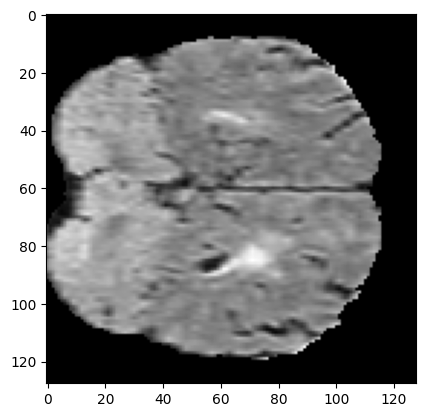

In [ ]:
plt.imshow(a[10, 3],cmap='gray')
print(b.shape)

torch.Size([128, 128])
torch.Size([128, 128])


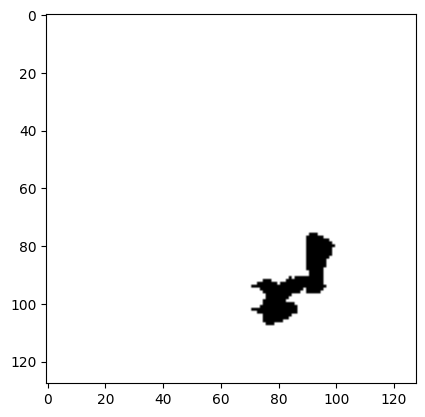

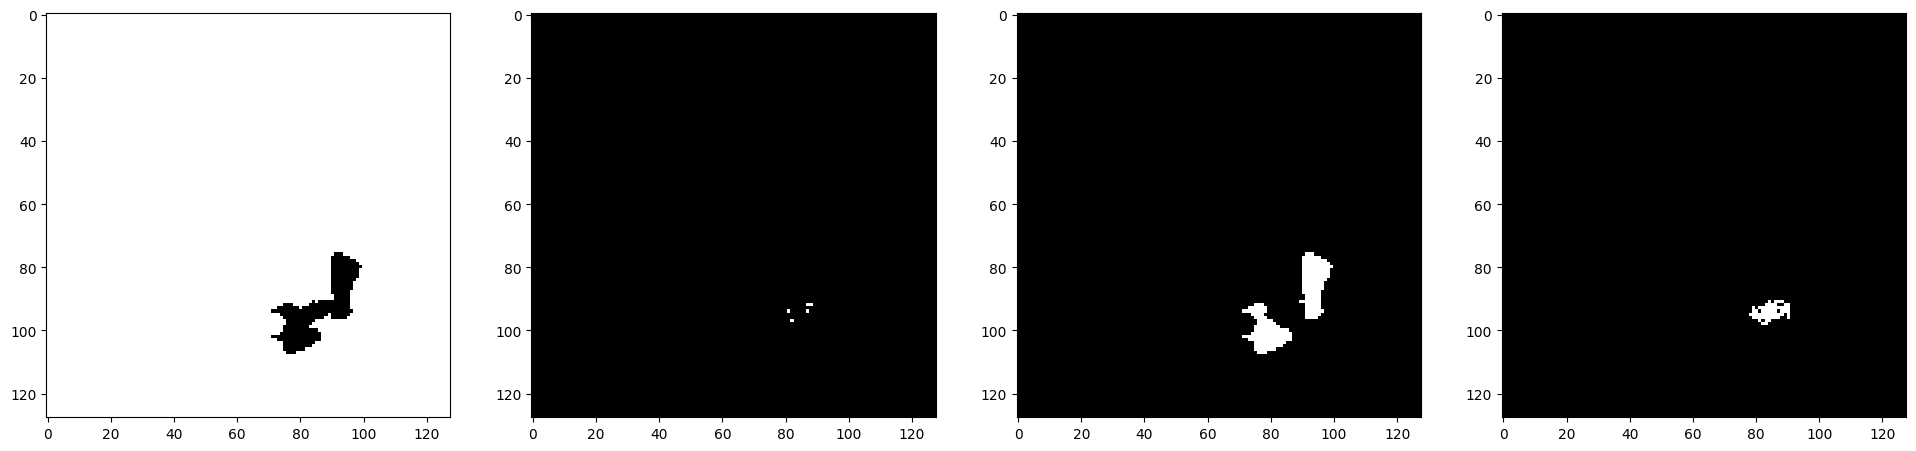

In [ ]:
plt.imshow(b[4, 0],cmap='gray')
print(b[4, 0].size())
img = b[1, 0]
plt.imshow(img,cmap='gray')
print(img.shape)

fig = plt.figure(figsize = (24, 15))
imgnum = 1

plt.subplot(1, 4, 1)
plt.imshow(b[imgnum, 0],cmap='gray')

plt.subplot(1, 4, 2)
plt.imshow(b[imgnum, 1],cmap='gray')

plt.subplot(1, 4, 3)
plt.imshow(b[imgnum, 2],cmap='gray')

plt.subplot(1, 4, 4)
plt.imshow(b[imgnum, 3],cmap='gray')

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Thu May 25 13:22:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    45W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torch import nn
import torch


@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    #concatenation 하기위해 decoder size맞춰 encoder size crop

    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]#index 2부터 마지막 요소까지 가져옴
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        """assert [조건], [오류메시지]
        assert 키워드 뒤에 [조건]을 입력하고 그 뒤에 콤마(,) [오류메시지]를 입력합니다.이 asset는 [조건]이 True인 경우 그대로 코드 진행, False인 경우 어설트에러 발생"""
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),#리스트 중간에 있는 ((ds[0] - es[0]) // 2) 부터((ds[0] + es[0]) // 2) 까지 데이터를 가져옴
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[#
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),#// : 나누기 후 소수점 이하의 수 버림
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):#str data 받아옴
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)#leaky relu는 임계치보다 작을 때 0을 출력하는 relu와는 달리 0.01을 곱합니다.
    elif activation == 'elu':
        return nn.ELU()#Applies the Exponential Linear Unit (ELU)


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)#batch normalization은 학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화하는 것을 뜻합니다
            #data standard gaussian화 시킴
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)#BN의 경우에는 batch 전체에서 계산이 이뤄지며, 각 batch에서 동일하게 계산합니다. 하지만 LN의 경우에는 각 특성에 대하여 따로 계산이 이뤄지며, 각 특성에 독립적으로 계산합니다
            #Instance Normalization 은 LN과 유사하지만, 한 단계 더 나아가 평균과 표준 편차를 구하여 각 example의 각 채널에 정규화를 진행합니다.
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)# GN의 경우에는 LN과 IN의 절충된 형태로 볼 수 있는데, 각 채널을 N개의 group으로 나누어 normalize 시켜주는 기술


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)# torch.cat()은 주어진 차원을 기준으로 주어진 텐서들을 붙입(concatenate)니다. torch.stack()은 새로운 차원으로 주어진 텐서들을 붙입니다

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):#**: keyword arguments만 받을 때
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

In [ ]:
MODEL = smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    decoder_use_batchnorm=True,
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 249MB/s]


In [ ]:
backgroundchannel = [0]

DICE_LOSS = smp.utils.losses.DiceLoss(activation = 'softmax2d')  

OPTIMIZER = torch.optim.Adam([ 
                                dict(params=MODEL.parameters(), lr = 0.0003),
                             ])
METRICS = [
              smp.utils.metrics.IoU(threshold = 0.5,ignore_channels = backgroundchannel, activation = 'softmax2d'),
              smp.utils.metrics.Fscore(ignore_channels = backgroundchannel, activation = 'softmax2d'),
          ]

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
                                            model = MODEL,
                                            loss = DICE_LOSS,
                                            metrics = [],
                                            optimizer = OPTIMIZER,
                                            device = DEVICE,
                                            verbose = True
                                        )
valid_epoch = smp.utils.train.ValidEpoch(
                                            model = MODEL,
                                            loss = DICE_LOSS,
                                            metrics = METRICS,
                                            device = DEVICE,
                                            verbose = True
                                        )

max_dice_score = 0
stats = {
          'train_loss' : [],
          'valid_loss' : [],
          'fscore' : [],
          'iou_score' : []
        }

for i in range(50):
  print(f'\n --- Epoch {i} --- ')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)
  
  if max_dice_score < valid_logs['fscore']:
      max_dice_score = valid_logs['fscore']
      torch.save(MODEL.state_dict(), f'./model.pth')
      print('model saved!')
  
  # loss statistics
  stats['train_loss'].append(train_logs['dice_loss'])
  stats['valid_loss'].append(valid_logs['dice_loss'])

  # metric statistics
  stats['fscore'].append(valid_logs['fscore'])
  stats['iou_score'].append(valid_logs['iou_score'])
  np.save(f'./model.npy', stats)
  


 --- Epoch 0 --- 
valid: 100%|██████████| 999/999 [00:15<00:00, 64.78it/s, dice_loss - 0.08886, iou_score - 0.4501, fscore - 0.5639]
model saved!

 --- Epoch 1 --- 
valid: 100%|██████████| 999/999 [00:15<00:00, 66.01it/s, dice_loss - 0.0378, iou_score - 0.5335, fscore - 0.6427]
model saved!

 --- Epoch 2 --- 
valid: 100%|██████████| 999/999 [00:15<00:00, 64.72it/s, dice_loss - 0.02793, iou_score - 0.5646, fscore - 0.675]
model saved!

 --- Epoch 3 --- 
valid: 100%|██████████| 999/999 [00:14<00:00, 66.69it/s, dice_loss - 0.02352, iou_score - 0.5797, fscore - 0.6855]
model saved!

 --- Epoch 4 --- 
valid: 100%|██████████| 999/999 [00:14<00:00, 69.63it/s, dice_loss - 0.02488, iou_score - 0.5531, fscore - 0.662]

 --- Epoch 5 --- 
valid: 100%|██████████| 999/999 [00:14<00:00, 69.02it/s, dice_loss - 0.02047, iou_score - 0.5943, fscore - 0.6989]
model saved!

 --- Epoch 6 --- 
valid: 100%|██████████| 999/999 [00:14<00:00, 70.98it/s, dice_loss - 0.01918, iou_score - 0.6066, fscore - 0.7095]


Text(0.5, 1.0, 'Train and Validation Loss')

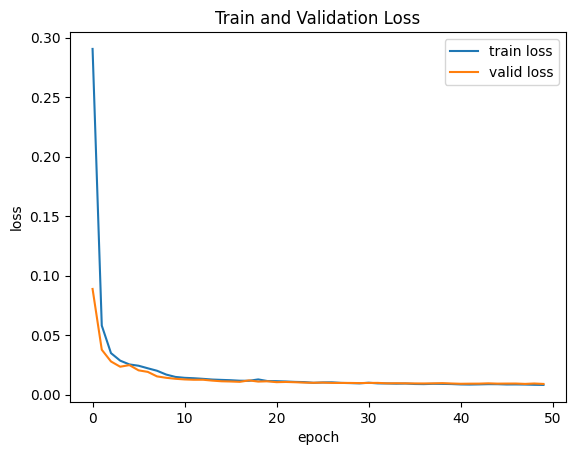

In [ ]:
STATS = np.load(f'./model.npy', allow_pickle = 'TRUE').item()
plt.plot(STATS['train_loss'], label = 'train loss')
plt.plot(STATS['valid_loss'], label = 'valid loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation Loss')

Text(0.5, 1.0, 'Fscore')

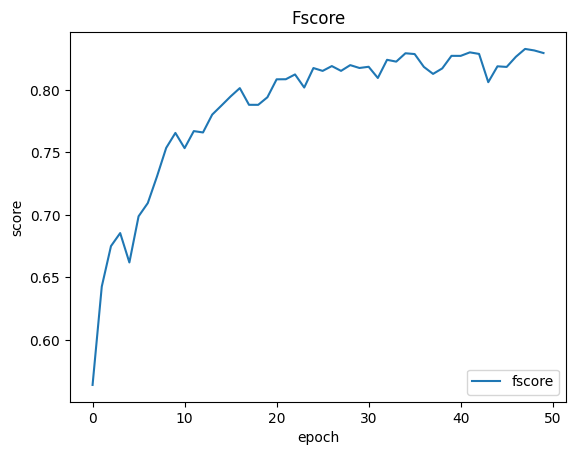

In [ ]:
STATS = np.load(f'./model.npy', allow_pickle = 'TRUE').item()
plt.plot(STATS['fscore'], label = 'fscore')
plt.legend(loc = "lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Fscore')

In [ ]:
MODEL.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    out = MODEL(a.cuda())

Text(0.5, 1.0, 'Prediction')

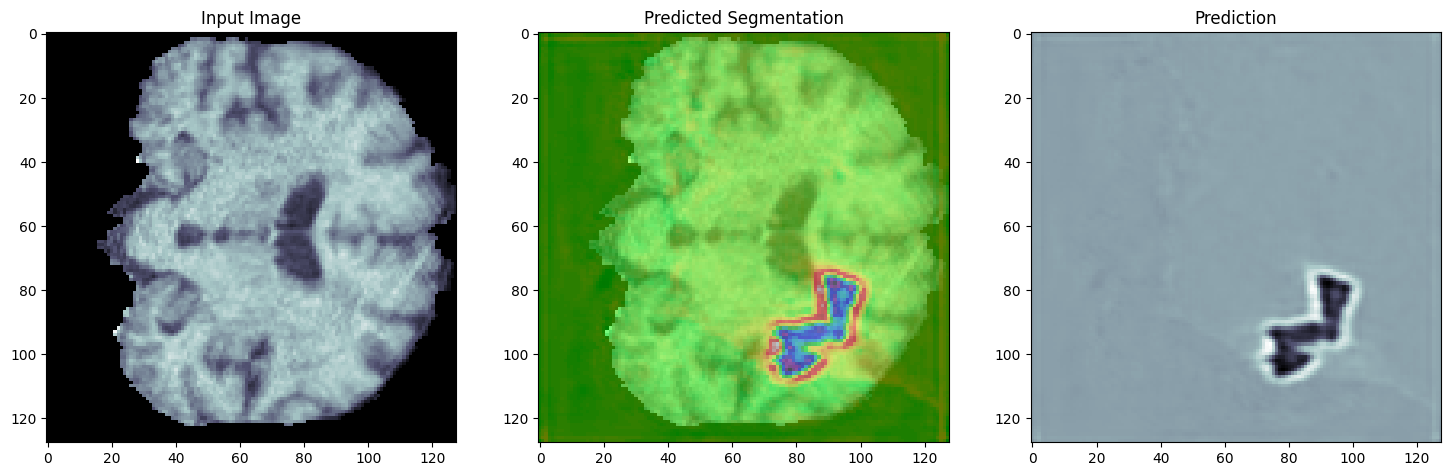

In [ ]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 3, 1)
plt.imshow(a[1, 0],cmap='bone')
plt.title('Input Image')
plt.subplot(1, 3, 2)
plt.imshow(a[1, 0],cmap='bone')
plt.imshow(out.cpu()[1, 0], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Predicted Segmentation')
plt.subplot(1, 3, 3)
plt.imshow(out.cpu()[1, 0], cmap = 'bone')
plt.title('Prediction')

Text(0.5, 1.0, 'Prediction')

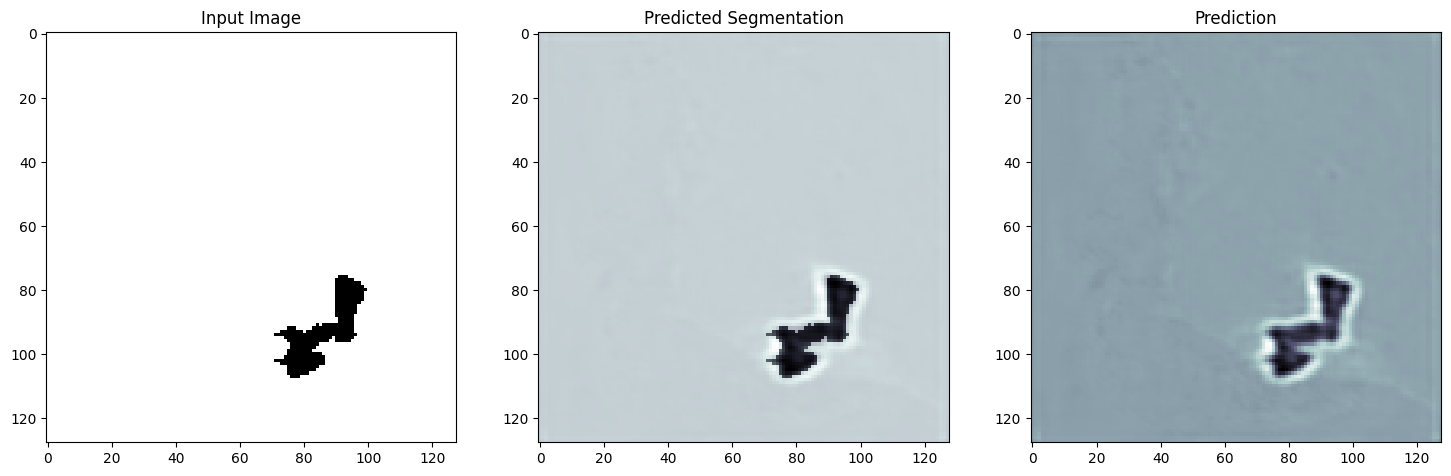

In [ ]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 3, 1)
plt.imshow(b[1, 0],cmap='bone')
plt.title('Input Image')
plt.subplot(1, 3, 2)
plt.imshow(b[1, 0],cmap='bone')
plt.imshow(out.cpu()[1, 0], alpha = 0.5, cmap = 'bone')
plt.title('Predicted Segmentation')
plt.subplot(1, 3, 3)
plt.imshow(out.cpu()[1, 0], cmap = 'bone')
plt.title('Prediction')

In [11]:
from sklearn.preprocessing import minmax_scale

mkdir: cannot create directory ‘figure10’: File exists


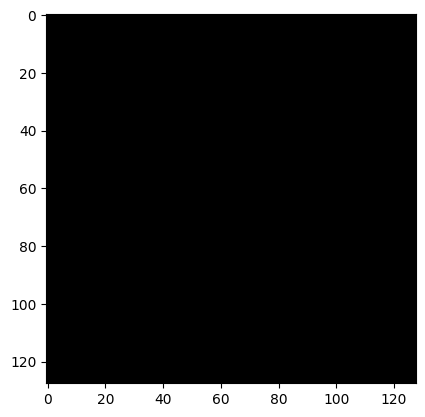

In [16]:
#numpy로 파일 가져오기
flair = np.load('/content/drive/MyDrive/졸업설계2/3D_dataset/flair/img_100.npy')
t1 = np.load('/content/drive/MyDrive/졸업설계2/3D_dataset/t1/img_100.npy')
t1ce = np.load('/content/drive/MyDrive/졸업설계2/3D_dataset/t1ce/img_100.npy')
t2 = np.load('/content/drive/MyDrive/졸업설계2/3D_dataset/t2/img_100.npy')
gt = np.load('/content/drive/MyDrive/졸업설계2/3D_dataset/seg/img_100.npy')

flair = flair.astype(np.float32)
t1 = t1.astype(np.float32)
t1ce = t1ce.astype(np.float32)
t2 = t2.astype(np.float32)

flair = torch.from_numpy(flair)#numpy array tensor로, 값 변경하면 반영됨
t1 = torch.from_numpy(t1)
t1ce = torch.from_numpy(t1ce)
t2 = torch.from_numpy(t2)


# stacking multi ins, image 새로운 차원으로 쌇음
input = torch.stack(
          
                     [t1,
                      t1ce,
                      t2,
                      flair], dim = 0
                                      )



! mkdir figure10
for i in range(128):
  flair_slice = minmax_scale(flair[:,:,i], (0, 1))*255
  plt.imshow(flair_slice ,'bone')
  plt.savefig(os.path.join('/content/drive/MyDrive/졸업설계2/figure10', f'{i}.png'), dpi=150)
  '''
  input_slice = input[:,:,:,i]
  print(input_slice.shape)
  input_slice=torch.unsqueeze(input_slice, 0)  
  print(input_slice.shape)

  with torch.no_grad():
    out = MODEL(input_slice.cuda())
  out = out.cpu()[0, 0] 
  out = out.numpy()
  
  out = minmax_scale(out, (0, 1))*255
  #out = out.astype(np.uint8)
  plt.imshow(out,cmap='nipy_spectral')
  plt.savefig(os.path.join('/content/drive/MyDrive/졸업설계2/figure9', f'{i}.png'), dpi=150)
  '''



In [17]:

import imageio
gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 0.1 ## 다음 화면으로 넘어가는 시간
}
 
## gif로 만들 이미지를 리스트로 만들어 줌
images = [plt.imread(os.path.join('/content/drive/MyDrive/졸업설계2/figure10', x)) for x in os.listdir('/content/drive/MyDrive/졸업설계2/figure10')]
## mimwrite 대신 mimsave로도 가능
imageio.mimwrite(os.path.join('/content/drive/MyDrive/졸업설계2/figure10', 'result.gif'), ## 저장 경로
                 images, ## 이미지 리스트
                 format='gif', ## 저장 포맷
                 **gif_config ## 부가 요소
                )